# DIGIT CLASSIFICATION USING MNIST DATA (INCEPTION NETWORK)

**Import necessary packages and modules**

In [1]:
import time
import random
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import progressbar
import matplotlib
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

**Set random seed of numpy and tensorflow to make the result reproducible**

In [2]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 88
tf_rand_seed = 33
np.random.seed(np_rand_seed)
tf.set_random_seed(tf_rand_seed)
print("random seed of numpy: ", np_rand_seed)
print("random seed of tensorflow: ", tf_rand_seed)

random seed of numpy:  88
random seed of tensorflow:  33


## 1. Loading and preprocess training data

**Load data**

In [3]:
# read the train data
train_data = pd.read_csv('../input/train.csv')

In [4]:
print("shape of train_data:",train_data.shape)

shape of train_data: (42000, 785)


In [5]:
# display the head of data
train_data.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Extract the features and output of the data**

In [6]:
# extract features and output 
features = train_data.columns.tolist()
output = "label"
features.remove(output)

**Dimension of images**

In [7]:
# image dimensions
width = 28
height = 28

**Reshape the features data into images**

In [8]:
# extract feature matrix
train_X = train_data[features].values
train_X = train_X/255.0
# reshape the data into image
train_X = train_X.reshape((-1, 28,28))

**Extract the labels and one hot encode the labels**

In [9]:
# extract labels
train_y = train_data[output].values
train_y = train_y.astype(int)
# one hot enncode the labels
train_y = pd.get_dummies(train_y).values

**Shape of Xy data of training set**

In [10]:
print("shape of train_X:",train_X.shape)
print("shape of train_y:",train_y.shape)

shape of train_X: (42000, 28, 28)
shape of train_y: (42000, 10)


**Train validation split**

In [11]:
# generate indices for training and validation sets randomly
train_indices = np.random.choice(len(train_y), round(len(train_y)*0.95), replace=False)
validation_indices = np.array(list(set(range(len(train_y))) - set(train_indices)))
# extract images for train and validation set
image_train = train_X[train_indices]
image_validation = train_X[validation_indices]
# extract labels for train and validation set
labels_train = train_y[train_indices]
labels_validation = train_y[validation_indices]

## 2. Augment Training set

### 2.1 Functions to carry out different types of image augmentation**

**Image Rotation**

In [12]:
def rotate_image(img, angle = 20):    
    '''
    a function to rotate image by a given degree
    '''    
    # rotate image
    copy = img.copy()
    M_rotate = cv2.getRotationMatrix2D((14,14),angle,1)
    img_new = cv2.warpAffine(copy,M_rotate,(28,28))
    return img_new

**Horizontal translation**

In [13]:
def translate_horizontal(image, shift_horizontal = 5):
    '''
    A function to translate image horizontally by a shift
    '''
    # horizontally shift image
    img = image.copy()
    
    shift_vertical = 0
    M_translate = np.float32([[1,0,shift_horizontal],[0,1,shift_vertical]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
    
    return img_new.reshape(28,28).astype(np.float32)

**Vertical translation**

In [14]:
def translate_vertical(image, shift_vertical = 5):
    
    '''a function to translate image vertically by a shift'''
    
    # vertically shift image
    img = image.copy()
    
    shift_horizontal = 0;
    if shift_vertical<0:
        image_slice = img[shift_vertical:,:].copy()
    if shift_vertical>0:
        image_slice = img[:shift_vertical,:].copy()
    M_translate = np.float32([[1,0,shift_horizontal],[0,1,shift_vertical]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
    
    return img_new.reshape(28,28).astype(np.float32)

**Translation along positive diagonal**

In [15]:
def translate_positive_diagonal(image, shift_diagonal = 5):
    
    '''a function to translate image along positive diagonal'''
    
    # translate image along positive diagonal
    img = image.copy()
    
    if shift_diagonal<0:
        hor_slice = img[shift_diagonal:,:].copy()
        ver_slice = img[:,shift_diagonal:].copy()
    else:
        hor_slice = img[:shift_diagonal,:].copy()
        ver_slice = img[:,:shift_diagonal].copy()
    M_translate = np.float32([[1,0,shift_diagonal],[0,1,shift_diagonal]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
    
    return img_new.reshape(28,28).astype(np.float32)

**Translation along negative diagonal**

In [16]:
def translate_negative_diagonal(image, shift_diagonal = 5):
    
    '''a function to translate image along negative diagonal'''
    
    # translate image along negative diagonal
    img = image.copy()
    
    if shift_diagonal<0:
        hor_slice = img[:-shift_diagonal,:].copy()
        ver_slice = img[:,shift_diagonal:].copy()
    if shift_diagonal>0:
        hor_slice = img[-shift_diagonal:,:].copy()
        ver_slice = img[:,:shift_diagonal].copy()
    M_translate = np.float32([[1,0,shift_diagonal],[0,1,-shift_diagonal]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
        
    return img_new.reshape(28,28).astype(np.float32)

**Zoom image**

In [17]:
def zoom(image, zoom_shift = 5):
    
    '''a function to zoom image'''
    
    # zoom image
    img = image.copy()
    
    # zoom in 
    if zoom_shift>0:
        # scale
        img_new = cv2.resize(img, (28+zoom_shift*2,28+zoom_shift*2)) 
        # crop
        img_new = img_new[zoom_shift:-zoom_shift,zoom_shift:-zoom_shift] 
    # zoom out
    else:
        zoom_shift *=-1        
        # scale
        img_new = cv2.resize(img, (28-zoom_shift*2,28-zoom_shift*2)) 
        # zero padding
        img_new = cv2.copyMakeBorder(img_new,zoom_shift,zoom_shift,zoom_shift,zoom_shift,
                                     cv2.BORDER_CONSTANT,value=0.0) 
        
    return img_new.reshape(28,28).astype(np.float32)

**Visualize the image transformations**

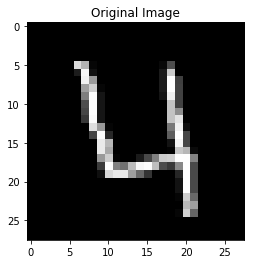

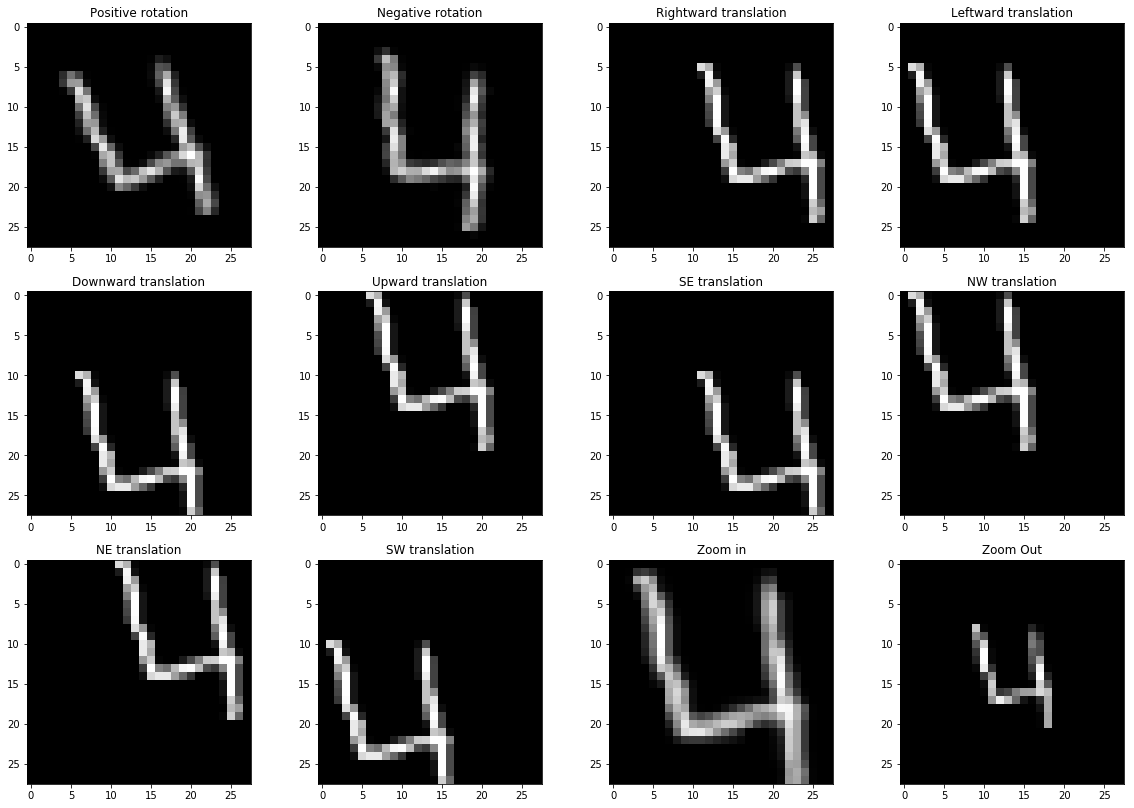

In [18]:
image = train_X[3]
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.show()
matplotlib.rcParams['figure.figsize'] = (20.0, 14.0)
generated_image = rotate_image(image,10)
plt.subplot(3,4,1)
plt.title("Positive rotation")
plt.imshow(generated_image, cmap='gray')
generated_image = rotate_image(image,-10)
plt.subplot(3,4,2)
plt.title("Negative rotation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_horizontal(image,5)
plt.subplot(3,4,3)
plt.title("Rightward translation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_horizontal(image,-5)
plt.subplot(3,4,4)
plt.title("Leftward translation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_vertical(image,5)
plt.subplot(3,4,5)
plt.title("Downward translation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_vertical(image,-5)
plt.subplot(3,4,6)
plt.title("Upward translation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_positive_diagonal(image,5)
plt.subplot(3,4,7)
plt.title("SE translation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_positive_diagonal(image,-5)
plt.subplot(3,4,8)
plt.title("NW translation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_negative_diagonal(image,5)
plt.subplot(3,4,9)
plt.title("NE translation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_negative_diagonal(image,-5)
plt.subplot(3,4,10)
plt.title("SW translation")
plt.imshow(generated_image, cmap='gray')
generated_image = zoom(image,5)
plt.subplot(3,4,11)
plt.title("Zoom in")
plt.imshow(generated_image, cmap='gray')
generated_image = zoom(image,-5)
plt.subplot(3,4,12)
plt.title("Zoom Out")
plt.imshow(generated_image, cmap='gray')
plt.show()

### 2.2 Augment training set

In [19]:
def augment_data(image, labels):
    
    '''a function to augment band1 and band2 image'''
    
    # list to store the generated data
    image_generated = []
    labels_generated = []
    
    # iterate through each point in train set
    for i in range(labels.shape[0]):
        
        # rotate by positive degree
        angle = np.random.randint(1,8)
        image_generated.append(rotate_image(image[i],angle)) 
        labels_generated.append(labels[i])
        
        # rotate by negative degree
        angle = np.random.randint(1,8)
        image_generated.append(rotate_image(image[i],-angle)) 
        labels_generated.append(labels[i])
        
        # positive horizontal shift
        shift = np.random.randint(1,5)
        image_generated.append(translate_horizontal(image[i],+shift)) 
        labels_generated.append(labels[i])
        
        # negative horizontal shift
        shift = np.random.randint(1,5)
        image_generated.append(translate_horizontal(image[i],-shift)) 
        labels_generated.append(labels[i])
        
        # positive vertical shift
        shift = np.random.randint(1,5)
        image_generated.append(translate_vertical(image[i],+shift)) 
        labels_generated.append(labels[i])
        
        # negative vertical shift
        shift = np.random.randint(1,5)
        image_generated.append(translate_vertical(image[i],-shift)) 
        labels_generated.append(labels[i])
        
        # translate along positive diagonal in positive direction
        shift = np.random.randint(1,5)
        image_generated.append(translate_positive_diagonal(image[i],+shift)) 
        labels_generated.append(labels[i])
        
        # translate along positive diagonal in negative direction
        shift = np.random.randint(1,5)
        image_generated.append(translate_positive_diagonal(image[i],-shift)) 
        labels_generated.append(labels[i])
        
        # translate along negative diagonal in positive direction
        shift = np.random.randint(1,5)
        image_generated.append(translate_negative_diagonal(image[i],+shift)) 
        labels_generated.append(labels[i])
        
        # translate along negative diagonal in negative direction
        shift = np.random.randint(1,5)
        image_generated.append(translate_negative_diagonal(image[i],-shift)) 
        labels_generated.append(labels[i])
        
        # zoom in image
        zoom_shift = np.random.randint(1,3)
        image_generated.append(zoom(image[i],zoom_shift)) 
        labels_generated.append(labels[i])
        
        # zoom out image
        zoom_shift = np.random.randint(1,3)
        image_generated.append(zoom(image[i],-zoom_shift)) 
        labels_generated.append(labels[i])        
        
    # convert the generated data into numpy array
    image_generated = np.array(image_generated)
    labels_generated = np.array(labels_generated)
    
    # concatenate the generated data to original train set
    image_augmented = np.concatenate((image, image_generated),axis=0)
    labels_augmented = np.concatenate((labels, labels_generated),axis=0)
    
    return image_augmented, labels_augmented

**Augment image and labels of training set**

In [20]:
image_train, labels_train = augment_data(image_train, labels_train)

In [21]:
print("Shape of image_train:",image_train.shape)
print("Shape of image_validation:",image_validation.shape)

Shape of image_train: (518700, 28, 28)
Shape of image_validation: (2100, 28, 28)


In [22]:
image_train = image_train[:,:,:,np.newaxis]
image_validation = image_validation[:,:,:,np.newaxis]

In [23]:
print("Shape of image_train:",image_train.shape)
print("Shape of image_validation:",image_validation.shape)

Shape of image_train: (518700, 28, 28, 1)
Shape of image_validation: (2100, 28, 28, 1)


## 3. Create functions to create & train Inception network, and to create submission file

**If a GPU is available then set our device of choice to the available GPU**

In [24]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)
if len(devices)>1:
    device = devices[1].name
else:
    device = devices[0].name

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6511942191083726385
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15864515789
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6277664635923015555
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


**Reset the default graph**

In [25]:
tf.reset_default_graph()

### 3.1 A function to create inception module

In [26]:
def create_inception_module(X, num_filters):    
    '''
    A function which creates inception modules given input and number of filters
    '''
    num_filters_single_conv = num_filters//4

    with tf.device(device):
        one_by_one_1 = tf.layers.conv2d(X, filters=num_filters_single_conv, kernel_size=1, strides=[1,1],
                                        kernel_initializer=tf.variance_scaling_initializer(),padding="SAME")

    with tf.device(device):
        three_by_three = tf.layers.conv2d(X, filters=num_filters_single_conv, kernel_size=1, strides=[1,1],
                                          kernel_initializer=tf.variance_scaling_initializer(),padding="SAME")
        three_by_three = tf.layers.conv2d(three_by_three, filters=num_filters_single_conv, kernel_size=3, strides=[1,1],
                                          kernel_initializer=tf.variance_scaling_initializer(),padding="SAME")

    with tf.device(device):
        five_by_five = tf.layers.conv2d(X, filters=num_filters_single_conv, kernel_size=1, strides=[1,1],
                                        kernel_initializer=tf.variance_scaling_initializer(),padding="SAME")
        five_by_five = tf.layers.conv2d(five_by_five, filters=num_filters_single_conv, kernel_size=5, strides=[1,1],
                                        kernel_initializer=tf.variance_scaling_initializer(),padding="SAME")

    with tf.device(device):
        one_by_one_2 = tf.layers.max_pooling2d(X, 3, 1, padding='SAME')
        one_by_one_2 = tf.layers.conv2d(one_by_one_2, filters=num_filters_single_conv, kernel_size=1, strides=[1,1],
                                        kernel_initializer=tf.variance_scaling_initializer(),padding="SAME")

    with tf.device(device):
        conv = tf.concat((one_by_one_1, three_by_three, five_by_five, one_by_one_2), axis=3)

    return conv

### 3.2 A function to create Inception CNN Network by embedding a number of inception modules**

In [27]:
def create_cnn_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NUM_CLASSES,
                   conv_filters, max_pool_kernel_size, max_pool_strides, dense_layers, learning_rate):
    '''
    A function to create Inception CNN Network by embedding a number of inception modules
    '''    
    # placeholders for image and prediction data
    X = tf.placeholder(tf.float32, shape=[None,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    Y = tf.placeholder(tf.int32, shape=[None, NUM_CLASSES])
    # keep probability for dropout
    keep_prob = tf.placeholder(tf.float32)
     # placeholder for mode of batch normalization
    training = tf.placeholder(tf.bool)
    
    print("####################################### DNN LAYERS #######################################")
    
    # iterate and create inception layers
    for n, conv_filter in enumerate(conv_filters):
        # first inception layer (with batch normalization)
        if n == 0:            
            conv = create_inception_module(X, conv_filter)
            print(conv)
            conv = tf.nn.elu(conv)
            print(conv)
            conv = tf.layers.batch_normalization(conv, training=training)
            print(conv)
            conv = tf.layers.max_pooling2d(conv, max_pool_kernel_size, max_pool_strides, padding='SAME')
            print(conv)
        # last inception layer (with batch normalization)
        elif n == len(conv_filters)-1:            
            conv = create_inception_module(conv, conv_filter)
            print(conv)
            conv = tf.nn.elu(conv)
            print(conv)
        # last inception layer (with batch normalization)
        else:
            conv = create_inception_module(conv, conv_filter)
            print(conv)
            conv = tf.nn.elu(conv)
            print(conv)
            conv = tf.layers.batch_normalization(conv, training=training)
            print(conv)
            conv = tf.layers.max_pooling2d(conv, max_pool_kernel_size, max_pool_strides, padding='SAME')
            print(conv)
    
    # flatten the last layer of convolution
    with tf.device(device):
        conv_flatten = tf.layers.Flatten()(conv)
    print(conv_flatten)    
     
     # iterate and create the dense layer
    for n, dense_layer in enumerate(dense_layers):
        # first dense layer (with dropout)
        if n == 0:
            with tf.device(device):
                Y_ = tf.layers.dense(conv_flatten, dense_layer, kernel_initializer=tf.variance_scaling_initializer(), activation=tf.nn.elu)
                print(Y_)
                Y_ = tf.nn.dropout(Y_, keep_prob=keep_prob)
                print(Y_)
         # last dense layer (without dropout)
        elif n == len(dense_layers)-1:
            with tf.device(device):
                Y_ = tf.layers.dense(Y_, dense_layer, kernel_initializer=tf.variance_scaling_initializer())
                print(Y_)
        # middle dense layers (with droput)
        else:
            with tf.device(device):
                Y_ = tf.layers.dense(Y_, dense_layer, kernel_initializer=tf.variance_scaling_initializer(), activation=tf.nn.elu)
                print(Y_)
                Y_ = tf.nn.dropout(Y_, keep_prob=keep_prob)
                print(Y_)
                
    print("############################################################################################")
    
    # softmax of output
    Y_pred = tf.nn.softmax(Y_)
    # compute predicted class
    Y_pred_cls = tf.argmax(Y_pred, axis=1, output_type=tf.int32)
    # compute true class
    Y_true_cls = tf.argmax(Y, axis=1, output_type=tf.int32)
    # compute correct prediction
    correct_prediction = tf.equal(Y_pred_cls, Y_true_cls)
    # compute accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # cross entropy cost operation           
    with tf.device(device):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Y_,labels=Y)
        cost = tf.reduce_mean(cross_entropy)
        
    # update operation
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    # optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    # train step
    with tf.control_dependencies(update_ops):
        with tf.device(device):
            # train step
            train_step = optimizer.minimize(cost)
                
    return X, Y, Y_pred_cls, keep_prob , training, train_step, cost, accuracy

### 3.2 A function to train CNN network

In [28]:
def train_cnn_net(max_iter,batch_size,
                  X, Y, keep_prob, training, train_step,cost, accuracy,
                  image_train, image_validation,labels_train, 
                  labels_validation, train_indices, model_dir, model_name):    
    '''
    A function to train CNN network
    '''
    # start the timer
    start_time = time.time()
    # create a saver object
    saver = tf.train.Saver(max_to_keep=1)    
    # lists to store the train cost, validation cost, validation accuracy at each iteration
    train_cost = []
    valid_cost = []
    valid_acc = []
    # variables to store the accuracy and iteration of our best model
    best_accuracy = 0
    best_iteration = None
    # number of training data
    N = image_train.shape[0]
    # number of complete batches
    num_complete_mini_batches = math.floor(N/batch_size)
    # model path
    model_path = model_dir + model_name

    # create a graph session and optimize under it
    with tf.Session() as sess:
        # initialize global variables
        sess.run(tf.global_variables_initializer())
        # progress bar
        bar = progressbar.ProgressBar(maxval=max_iter, widgets=[
            '[',progressbar.Percentage(),']',
            progressbar.Bar(),
            '(',progressbar.DynamicMessage("train_cost"),')',
            '(',progressbar.DynamicMessage("valid_cost"),')',
            '(',progressbar.DynamicMessage("valid_accuracy"),')',
            '(',progressbar.DynamicMessage("best_accuracy"),')',
            '(',progressbar.DynamicMessage("time_elapsed"),'mins)'
        ])
        # start the progressbar
        bar.start()
        # counter variable to track the number of iterations
        counter = 0        
         # iterate until maximum number of iterations is reached
        while True:
            # break out of the inner for loop if maximum number of iterations is reached
            if counter>=max_iter:
                break
            # iterate through the mini batches
            for k in range(0, num_complete_mini_batches+1):
                # if the mini batch is a complete batch
                if k < num_complete_mini_batches:
                    batch_indices = np.array(list(range(k * batch_size, k * batch_size + batch_size)))
                # handling the end case when the last mini batch is less than the batch_size
                elif N % batch_size != 0:
                    batch_indices = np.array(list(range(num_complete_mini_batches * batch_size, N)))

                # extract images and labels of the batch
                image_rand_train = image_train[batch_indices]    
                labels_rand_train = labels_train[batch_indices]

                # feed dict for the batch
                feed_dict_batch =  {X: image_rand_train,
                                    Y: labels_rand_train,
                                    keep_prob: 0.6,
                                    training: True}

                # feed dict for validation set
                feed_dict_validation =  {X: image_validation,
                                         Y: labels_validation,
                                         keep_prob:1.0,
                                         training: False}

                # run optimizer step
                sess.run(train_step, feed_dict=feed_dict_batch)
                # compute train cost and append it to the designated list
                temp_train_cost = cost.eval(session=sess, feed_dict=feed_dict_batch)
                train_cost.append(temp_train_cost)
                # compute validation cost and append it to the designated list
                temp_validation_cost = cost.eval(session=sess, feed_dict=feed_dict_validation)
                valid_cost.append(temp_validation_cost)
                # compute validation accuracy and append it to the designated list
                temp_validation_accuracy = accuracy.eval(session=sess, feed_dict=feed_dict_validation)
                valid_acc.append(temp_validation_accuracy)   

                # if validation accuracy is better than best recorded so far then update the best valid accuracy
                if temp_validation_accuracy > best_accuracy:
                    best_accuracy = temp_validation_accuracy
                    best_iteration = counter+1
                    saver.save(sess, model_path, global_step = best_iteration)
                
                # calculate the elapsed time since training started 
                time_diff = (time.time()-start_time)/60

                # print metric info
                # update the progress bar
                bar.update(counter+1, train_cost = temp_train_cost, valid_cost = temp_validation_cost, 
                           valid_accuracy = temp_validation_accuracy,best_accuracy = best_accuracy, time_elapsed = time_diff)
                
                # increment counter variable
                counter += 1
                # break out of the inner for loop if maximum number of iterations is reached
                if counter>=max_iter:
                    break
        # finish the progress bar
        bar.finish()
            
    return saver, train_cost, valid_cost, valid_acc, best_accuracy, best_iteration

### 3.4 A function to create submission csv file

In [37]:
def create_predictions(model_path, X, Y_pred_cls, training, image_test, 
                       test_ids, n_folds, submission_dir, submission_file):
    '''
    A function to create predictions and submission file
    '''
    # submission path
    submission_path = submission_dir + submission_file
    
    with tf.Session() as sess:        
        # restore the best model
        saver.restore(sess, model_path)
        # break the test set into folds other wise kernel will be out of memory
        n = image_test.shape[0]
        step = n//n_folds
        # array to store the prediction
        preds = np.array([])
        
        # iterate through each fold
        for i in range(n_folds):
            # start and end indices of the fold
            start = (step*i)
            end = (step*(i+1)) 
            # feed dictionary for the fold
            feed_dict_test =  {X: image_test[start:end],
                               keep_prob: 1.0,
                               training: False}
            # evaluate predictions of the fold
            fold_preds = Y_pred_cls.eval(session=sess, feed_dict = feed_dict_test)
            # append the predictions of the fold to the designated array
            preds = np.append(preds, fold_preds)
            print("Finished computing predictions for fold", i)

        # convert the prediction vector to int
        preds = preds.astype(np.int)
        # save the submission csv file
        submission = pd.DataFrame({"ImageId": test_ids, "Label": preds})
        submission.to_csv(submission_path, header = True, index=False)

## 4. Create & train Inception Network and make a submission csv file

**Create Inception network**

In [30]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NUM_CLASSES = 28,28,1,10
conv_filters = [256,512,1024]
dense_layers = [2048,1024,512,256,10]
max_pool_kernel_size = 2
max_pool_strides = 2
learning_rate=0.00001*5
max_iter,batch_size = 2000, 512
X, Y, Y_pred_cls, keep_prob , training, train_step, cost, accuracy  = create_cnn_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NUM_CLASSES,
                                                                                     conv_filters, max_pool_kernel_size, max_pool_strides, 
                                                                                     dense_layers, learning_rate)

####################################### DNN LAYERS #######################################
Tensor("concat:0", shape=(?, 28, 28, 256), dtype=float32, device=/device:GPU:0)
Tensor("Elu:0", shape=(?, 28, 28, 256), dtype=float32)
Tensor("batch_normalization/cond/Merge:0", shape=(?, 28, 28, 256), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 14, 14, 256), dtype=float32)
Tensor("concat_1:0", shape=(?, 14, 14, 512), dtype=float32, device=/device:GPU:0)
Tensor("Elu_1:0", shape=(?, 14, 14, 512), dtype=float32)
Tensor("batch_normalization_1/cond/Merge:0", shape=(?, 14, 14, 512), dtype=float32)
Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("concat_2:0", shape=(?, 7, 7, 1024), dtype=float32, device=/device:GPU:0)
Tensor("Elu_2:0", shape=(?, 7, 7, 1024), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 50176), dtype=float32, device=/device:GPU:0)
Tensor("dense/Elu:0", shape=(?, 2048), dtype=float32, device=/device:GPU:0)
Tensor("dropout/mul:0", s

**Train incpetion network**

In [31]:
model_dir, model_name = "./model_files/", "model"
saver, train_cost, valid_cost, valid_acc, best_accuracy, best_iteration = train_cnn_net(max_iter,batch_size,
                                                                                        X, Y, keep_prob, training, train_step,cost, accuracy,
                                                                                        image_train, image_validation,labels_train, 
                                                                                        labels_validation, train_indices, model_dir, model_name)

[100%]||(train_cost: 0.0223)(valid_cost: 0.0235)(valid_accuracy:   0.99)(best_accuracy:  0.996)(time_elapsed:   30.7mins))


**Plot of Cost vs Iterations**

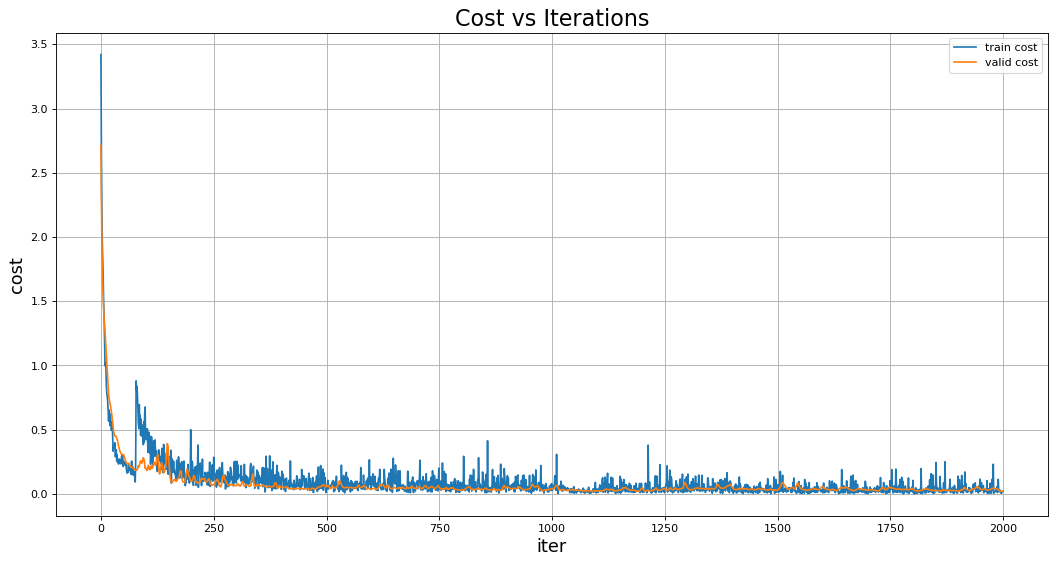

<Figure size 1440x1008 with 0 Axes>

In [32]:
figure_dir = "./model_cost_figures/"
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(train_cost, label = "train cost")
plt.plot(valid_cost, label = "valid cost")
plt.title("Cost vs Iterations", fontsize=20)
plt.xlabel("iter", fontsize=16)
plt.ylabel("cost",fontsize=16)
plt.legend()
plt.grid()
plt.show()
# save the figure in the designated directory
plt.savefig(figure_dir + 'cost_vs_iterations.png', bbox_inches='tight')

**Plot of Accuracy vs Iterations**

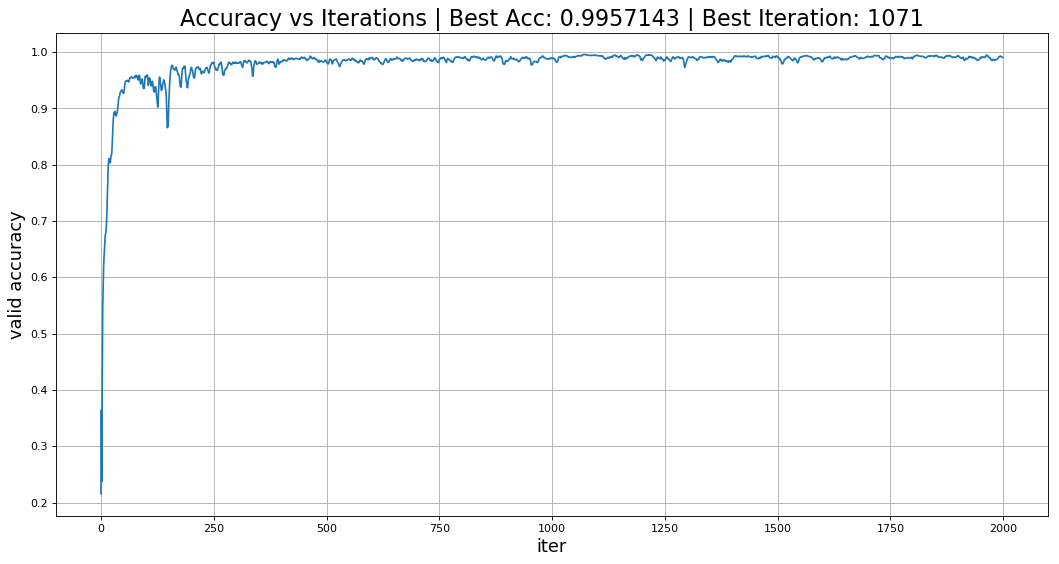

<Figure size 1440x1008 with 0 Axes>

In [33]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(valid_acc,)
plt.title("Accuracy vs Iterations | "+"Best Acc: "+str(best_accuracy)+" | Best Iteration: "+str(best_iteration), fontsize =20)
plt.xlabel("iter", fontsize =16)
plt.ylabel("valid accuracy", fontsize =16)
plt.grid()
plt.show()
# save the figure in the designated directory
plt.savefig(figure_dir + 'acc_vs_iterations.png', bbox_inches='tight')

**Load and preprocess test data**

In [34]:
test_data = pd.read_csv('../input/test.csv')
image_test = test_data[features].values
image_test = image_test.reshape((-1,28,28,1))
test_ids = test_data.index.tolist()
print(image_test.shape)
del(test_data)

(28000, 28, 28, 1)


**Create submission csv**

In [38]:
model_path = model_dir+model_name+"-"+str(best_iteration)
submission_dir = "./submission_files/"
submission_file = "submission.csv"
n_folds = 10
create_predictions(model_path, X, Y_pred_cls, training, image_test,
                   test_ids, n_folds, submission_dir, submission_file)

INFO:tensorflow:Restoring parameters from ./model_files/model-1071
Finished computing predictions for fold 0
Finished computing predictions for fold 1
Finished computing predictions for fold 2
Finished computing predictions for fold 3
Finished computing predictions for fold 4
Finished computing predictions for fold 5
Finished computing predictions for fold 6
Finished computing predictions for fold 7
Finished computing predictions for fold 8
Finished computing predictions for fold 9


**Display the submission file**

In [39]:
pd.read_csv(submission_dir+submission_file).head(20)

,ImageId,Label
0,0,2
1,1,0
2,2,9
3,3,0
4,4,3
5,5,7
6,6,0
7,7,3
8,8,0
9,9,3
